In [1]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='serif', serif='STIXGeneral', size=10)

def to_corr(x, ref):
    return (ref[0] - x) / (ref[0] - ref[1])
def to_corr_error(x, ref):
    return x / (ref[0] - ref[1])

In [2]:
f = h5py.File(f'{os.path.dirname(os.getcwd())}/data/raw/data_pub_diatomics.h5', 'a')
f_ref = h5py.File(f'{os.path.dirname(os.getcwd())}/data/raw/data_pub_diatomics_refereces.h5', 'a')

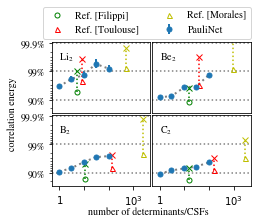

In [6]:
def plot_vmc_dmc(ax,dets,e_vmc,e_dmc,e_ref,label,color,marker):
    ax.plot(dets,1-to_corr(e_vmc,e_ref),label=f'Ref. [{label}]',ls=' ',fillstyle='none',marker=marker,color=color,ms=5)
    ax.plot(dets,1-to_corr(e_dmc,e_ref),ls=' ',marker='x',fillstyle='none',color=color)
    ax.plot([dets,dets],[1-to_corr(e_vmc,e_ref),1-to_corr(e_dmc,e_ref)],color=color,ls=':')
    

dets=[1,3,10,30,100]
systems = ['Li2','Be2','B2','C2']
refs = ['Filippi','Toulouse','Morales']
colors = ['g','r','y']
marker = ['o','^','^']
Es = np.array([[f[system][f'{d}det'].attrs['energy'] for d in dets] for system in systems])
ref_energies=np.array([f[system].attrs['ref_energy'] for system in systems])
y_ticks = np.concatenate([np.linspace(10**(i-3),10**(i-2),10) for i in range(3)])
width =3.5
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all', figsize= (width,width*3/4))

for i,axi,s,ek in zip(range(4),[ax1,ax2,ax3,ax4],systems,Es):
    for xi in [0.001,0.01,0.1]:
        axi.axhline(xi,ls=':',color='grey')
    axi.errorbar(dets,1-to_corr(ek[:,0],ref_energies[i]),to_corr_error(ek[:,1],ref_energies[i]),ms=5,marker='o',ls='',color='C0',linewidth=2,label='PauliNet')
    axi.plot(dets,1-to_corr(ek[:,0],ref_energies[i]),ls=':',color='grey',linewidth=2,zorder=0)
    for j,ref in enumerate(refs):
        plot_vmc_dmc(axi,f_ref[ref]['ndet'][...][i],f_ref[ref]['e_vmc'][...][...][i],f_ref[ref]['e_dmc'][...][...][i],f_ref['ref_energies'][s][...],ref,colors[j],marker[j])
    fig.tight_layout()
    axi.set_yscale('log')
    axi.set_xscale('log')
    axi.set_ylim(0.3,0.0009)
    axi.set_xlim(0.5,5_000)
    if i%2==0:
        axi.set_yticks([0.1,.01,.001])
        axi.set_yticks(y_ticks[y_ticks<0.3], minor=True)
        axi.set_yticklabels([r'90%',r'99%',r'99.9%'])
    else:
        axi.set_yticks([])
        axi.tick_params(axis='y', which='both', length=0)
    if i//2==1:
        axi.set_xticks([1,10,100,1000])
        axi.set_xticklabels(['$1$','','','$10^3$'])
    else:
        axi.set_xticks([])
        axi.tick_params(axis='x', which='both', length=0)
    axi.annotate('$\mathregular{{ {0} }}$'.format(s.replace('2','_2')),(1,0.004))

fig.subplots_adjust(wspace = 0.02, hspace = 0.03 )
fig.text(0.55, 0.03,'number of determinants/CSFs', ha='center', va='center')
fig.text(0.01, 0.55,  'correlation energy', ha='center', va='center', rotation='vertical')
plt.legend(loc = 0,bbox_to_anchor=(1.05,2.6),ncol=2)
#plt.savefig('diatomics.pdf',bbox_inches='tight')